# Проведение АА-тестов

По данным с '2022-01-24' по '2023-01-30', нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации нам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом. Сделать выводы об одинаковости выборок, корректоности работы системы сплитования

## 1. Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import seaborn as sns
import hashlib
import pandahouse as ph
import random

### 2. Выгрузка данных по условию

In [2]:
# функция для выполнения запосов
def select(q):
    return ph.read_clickhouse(q, connection=connection)

In [3]:
# устанавливаем параметры
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '*******',
    'user': '*******',
    'database': '*******'
}

In [4]:
# Выгрузка данных по условию: '2022-01-24' по '2023-01-30' и 2 и 3 экспериментальной группы
query = '''
select distinct t1.user_id as iser_id, CTR, exp_group from
(select user_id,
       countIf(action = 'view') as views, 
       countIf(action = 'like') as likes,
       countIf(user_id, action = 'like') / countIf(user_id, action='view') as CTR
from {db}.feed_actions 
group by user_id 
having  toDate(time) >= '2023-01-24' and toDate(time) <= '2023-01-30' and exp_group in (2,3)
order by views desc) t2
join 
(select user_id, exp_group from {db}.feed_actions) t1
using user_id

'''

In [5]:
df_group = select(query)  # сохраняем данныe по условию: '2022-01-24' по '2023-01-30' и 2 и 3 экспериментальной группы

In [6]:
df_group

,iser_id,CTR,exp_group
0,124755,0.162602,3
1,123760,0.163934,3
2,17547,0.173077,2
3,117685,0.141141,2
4,122945,0.150307,3
...,...,...,...
17044,114511,0.500000,3
17045,12827,0.000000,2
17046,119308,0.000000,3
17047,111366,0.000000,2


### 3. Проверка гипотез

Нулевая гипотеза(Н0) – средние двух выборок равны (средние пользовательские CTR равны), альтернативная гипотеза(Н1) – средние пользовательские CTR 2 и 3 экспериментальной группы различаются.

In [7]:
alpha = .05 # критический уровень статистической значимости

In [8]:
# проверка работы цикла и t-теста 
for i in range(3):
    group_2 = random.sample(set(df_group[df_group.exp_group == 2].iser_id), 5)
    group_3 = random.sample(set(df_group[df_group.exp_group == 3].iser_id), 5)
    df_group_2 = df_group[df_group['iser_id'].isin(group_2)]  
    df_group_3 = df_group[df_group['iser_id'].isin(group_3)]
    results = st.ttest_ind(df_group_2.CTR, 
           df_group_3.CTR, equal_var = False)
    print('p-значение:', results.pvalue)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    
    

p-значение: 0.40263780485554385
Не получилось отвергнуть нулевую гипотезу
p-значение: 0.8508817253586514
Не получилось отвергнуть нулевую гипотезу
p-значение: 0.9947046173068623
Не получилось отвергнуть нулевую гипотезу


In [9]:
l = [] # пустой список

In [10]:
for i in range(10000):
    group_2 = random.sample(set(df_group[df_group.exp_group == 2].iser_id), 500)  # рандомная выборка 500 элементов из датафрейма df_group
    group_3 = random.sample(set(df_group[df_group.exp_group == 3].iser_id), 500)
    df_group_2 = df_group[df_group['iser_id'].isin(group_2)]  # фильтруем датафрейм с данными по iser_id 
    df_group_3 = df_group[df_group['iser_id'].isin(group_3)]
    results = st.ttest_ind(df_group_2.CTR, 
           df_group_3.CTR, equal_var = False)
    l.append(results.pvalue) # добавляем в список значения p-value

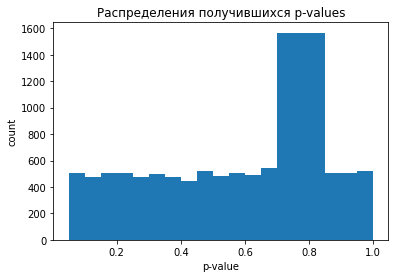

In [11]:
plt.title('Распределения получившихся p-values')
plt.hist(l, bins=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.85, 0.9, 0.95, 1])
plt.xlabel('p-value')
plt.ylabel('count')
plt.show()

In [12]:
print('Среднее значение p-value:', sum(l) / len(l))

Среднее значение p-value: 0.5066112181294166


In [13]:
print('Процент p-values меньше либо равен 0.05:', len([item for item in l if item <= 0.05]) / len(l) * 100, '%')

Процент p-values меньше либо равен 0.05: 4.760000000000001 %


### Вывод

Рассматривая распределение получившихся p-values и учитывая, что процент тестов, которые показывают изменения, т.е. отвергается нулевая гипотеза о равенстве,  меньше  чем в 5% случаях от всего количество проведенных тестов.
Согласно проведенному анализу, можно прийти к выводу, что выборки одинаковые, т.е. наша система сплитования корректно работает